In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import numpy as np
from scipy.stats import spearmanr

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

In [3]:
def filter_out_nan(origin):
    new_list = origin
    new_list = [x for x in new_list if str(x) != 'nan']
    return new_list

def palette_builder(cre_line, colour):
    palette = {}
    colours = filter_out_nan(colour)
    index = 0
    for cre in cre_line:
        palette[cre] = colours[index]
        index = index + 1
    return palette

In [4]:
# load all data from csvs stored in the repo

#csv file of all electrophysiology, morphology features, ion conductance, nm_id
all_features = pd.read_csv("all_features.csv", index_col=0)
#csv file of all electrophysiology, morphology features, ion conductance, nm_id, including cell type
all_features_cell_type = pd.read_csv("all_features_cell_type.csv", index_col=0)

abs_all_features = pd.read_csv("abs_all_features.csv", index_col=0)

abs_all_features_cell_type = pd.read_csv("abs_all_features_cell_type.csv", index_col=0)


#transcriptomic gene expression data by cell type
transcriptome_df = pd.read_csv("transcriptome_df.csv", index_col=0)
#transcriptomic gene expressions data with all separate cortical layers
new_transcriptome_df = pd.read_csv('sep_layer_df.csv', index_col=0)
#transcriptomic gene expression data with only cre-line
new_label_df = pd.read_csv("new_label_transcriptome_df.csv", index_col=0)

#relavtive ion conductance data for only cre-lines
cre_parameter_df = pd.read_csv("cre_parameter_df.csv", index_col=0)
#absolute ion conductance data for cell types
abs_parameter_df = pd.read_csv("abs_parameter_df.csv", index_col=0)
#relative conductance data for cell types
sep_layer_cre_parameter_df = pd.read_csv('sep_layer_cre_parameter_df.csv', index_col=0)

#csv for entrenz symbol and associated gene
entrenz_symbol_s = pd.read_csv("entrenz_symbol_s.csv", index_col=0, names = ['entrez_id', 'gene_symbol'])

#csv file about channel genes and their associated ion channels
ion_channel_genes = pd.read_csv("targets_and_families.csv", index_col=0)

#Spearman Correlation ranks at cre-line level
f = open("new_spearman_corr_ranks.json","r")
data = json.load(f)
spearman_corr_ranks = data
f.close()

#Spearman Correlation ranks for cell types and relative conductance
f = open("new_sep_spearman_corr_ranks.json","r")
data = json.load(f)
sep_spearman_corr_ranks = data
f.close()

#Spearman Correlation ranks for cell types and absolute conductance
#f = open("abs_spearman_corr_ranks.json","r")
#data = json.load(f)
#abs_spearman_corr_ranks = data
#f.close()



sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#Parameter names
org = pd.read_csv("org.csv", index_col=0)
parameters = list(org['parameters'])

#Parameter names for absolute conductance
abs_parameters = list('abs_' + org['parameters'])

#6 Parameters shared by all neuronal models
shared_parameters = filter_out_nan(list(org['shared']))

#Dictionary of the related genes to the 6 parameters
related_RNA = {}
for para in shared_parameters:
    related_RNA[para] = filter_out_nan(list(org[para]))

abs_related_RNA = {}
for para in shared_parameters:
    abs_related_RNA['abs_' + para] = filter_out_nan(list(org[para]))
abs_related_RNA

#List of gene channels that are voltage gated
ion_channel_genes = ion_channel_genes[ion_channel_genes['MGI symbol'].notnull()]
gene_channel = ion_channel_genes.loc["vgic"]
gene_channel = gene_channel['MGI symbol'].values
gene_channel = list(gene_channel)

gene_channel_vgic = ion_channel_genes.loc["vgic"]
gene_channel_vgic

exclude = []
for gene in list(gene_channel_vgic['Mouse Entrez Gene']):
    if int(gene) in list(transcriptome_df.index):
        if sum(list(transcriptome_df.loc[int(gene)]))/len(list(transcriptome_df.loc[int(gene)])) < .1:
            exclude.append(gene)
for excluded_gene in exclude:
    gene_channel_vgic_filtered = gene_channel_vgic[gene_channel_vgic['Mouse Entrez Gene'] != excluded_gene]
                
gene_channel_vgic_filtered

#Set-up for palette for cell types based on Cre-line
cre_color_inc_4 = filter_out_nan(list(org['cre_line']))
cre_line_palette_inc_4 = palette_builder(cre_color_inc_4, list(org['colour']))
    
shortened_color = filter_out_nan(list(org['short']))
shortened_palette = palette_builder(shortened_color, list(org['colour']))


In [5]:
#calculate the standard deviation and sem
def cal_std_sem(index_name):
    index_name = list(org['parameters'])
    index_name.append('cell_type')
    stdcal = all_features_cell_type[all_features_cell_type['gbar_Ih'].notna()]
    stdcal = stdcal[stdcal['cell_type'] != 'False']
    stdcal = stdcal[index_name]
    std = stdcal.groupby('cell_type').std()
    sem = stdcal.groupby('cell_type').sem()
    std.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    sem.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    return sem, std

#set sem and std to the values for standard deviation and sem for relative
sem, std = cal_std_sem(parameters)

#set sem and std to the values for standard deviation and sem for absolute
abs_sem, abs_std = cal_std_sem(abs_parameters)

In [6]:
def create_cre_conductance(parameter_type, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_4 , : ]
    return cre_conductance_filtered

def create_gene_spec_filtered(gene_symbol):
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inc_4])
    return gene_spec_filtered, gene_id

def rename_graph_spec(graph_spec):
    renaming_index = palette_builder(cre_color_inc_4, shortened_color)
    graph_spec.rename(index = renaming_index, 
                                 inplace = True)

In [7]:
def create_graph_spec(parameter_type, gene_symbol, df):
    cre_conductance_filtered = create_cre_conductance(parameter_type, df)
   
    gene_spec_filtered, gene_id = create_gene_spec_filtered(gene_symbol)
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    
    rename_graph_spec(graph_spec)
    
    return graph_spec

In [8]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp(parameter_type, gene_symbol, df, xlabel, ylabel, 
                                show_errorbars = True,
                                show_legend = True, 
                                show_best_line = True, 
                                poly_deg = 2 # degree of polynomial for fit
                               ):
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 

    # get standard errors
    std_cre = sem.loc[cre_color_inc_4,:]
    errors = std_cre[parameter_type]
    inv_errors = 1/errors
    
    # set up plot parameters
#     plt.figure(figsize=(7, 7))   
#     mpl.rcParams['pdf.fonttype'] = 42
#     mpl.rcParams['ps.fonttype'] = 42
#     plt.rcParams['svg.fonttype'] = 'none'
    
    graph_spec.sort_values(by=[gene_id], inplace = True)
    mini = graph_spec.iloc[0, :][gene_id]
    maxi = graph_spec.iloc[14, :][gene_id]
    
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
    
    # best fit line
    if(show_best_line):
        #z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=poly_deg, w=inv_errors)
        z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=poly_deg)
        p = np.poly1d(z)
        xp = np.linspace(mini, maxi, 100)
        _ = plt.plot(xp, p(xp), '-', zorder=1)
    
    # plot data points
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
    
    # legend handling
    if (show_legend):
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
    else:
        ax.get_legend().remove()
    
    
#     plt.rcParams['font.family'] = 'sans-serif'
#     plt.rcParams['font.sans-serif'] = ['Tahoma']
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

#     ax.xaxis.label.set_size(12)
#     ax.yaxis.label.set_size(12)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    if (show_errorbars):
        # Find the x,y coordinates for each point for errorbar plotting
        x_coords = []
        y_coords = []
        for point_pair in ax.collections:
            for x, y in point_pair.get_offsets():
                x_coords.append(x)
                y_coords.append(y)

        ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
    return ax
#     return(plt)


In [9]:
## define functions needed for creating histograms showing gene corr specificity

def create_matrix(parameter, abs_spearman_dict):
    d = {"correlation": list(abs_spearman_dict[parameter].values()), "symbol": list(abs_spearman_dict[parameter].keys())}
    test = pd.DataFrame(d)
    return test.sort_values(by=['correlation'])

def create_matrix_select(parameter, abs_spearman_dict, list_possible):
    d = {"symbol":[], "correlation":[]}
    i = 0
    check = list(abs_spearman_dict[parameter].keys())
    for stuff in list_possible:
        if stuff in check:
            correl = abs_spearman_dict[parameter][stuff]
            d['symbol'].append(stuff)
            d['correlation'].append(correl)
            i = i + 1
    test = pd.DataFrame(d)
    return test.sort_values(by=['correlation'])
 
def histo_corr_new(parameter, df, xlabel, ylabel, y_max_val = 1):
    test = create_matrix_select(parameter, df, gene_channel)
    sorted_test = test.sort_values(["correlation"], ascending=True)
    clrs = []
    pos = []
    label = []
    p = 0
    for item in sorted_test['symbol']:
        if item in related_RNA[parameter]:
            clrs.append('blue')
            pos.append(p)
            label.append(item)
            p += 1
        else:
            clrs.append('red')
            p += 1
# #     plt.figure(figsize=(20, 7))   
#     mpl.rcParams['pdf.fonttype'] = 42
#     mpl.rcParams['ps.fonttype'] = 42
#     plt.rcParams['svg.fonttype'] = 'none'
    ax = sns.barplot(x = 'symbol', y='correlation', data=sorted_test ,palette = clrs)
#     plt.rcParams['font.family'] = 'sans-serif'
#     plt.rcParams['font.sans-serif'] = ['Tahoma']
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

#     ax.xaxis.label.set_size(30)
#     ax.yaxis.label.set_size(30)
    ax.set(ylabel=ylabel, xlabel=xlabel)
    ax.axes.set_ylim([-y_max_val, y_max_val])
#     location = test['correlation'].iloc[-1] /4
    
#     for i in range(len(label)) :
#         if i > 0:
#             if pos[i] - pos[i-1] < 5:
#                 location = location + test['correlation'].iloc[-1] /4
#         if (test[test['symbol']==label[i]]['correlation'].iloc[0]) < 0:
            
#             ax.annotate(label[i],
#                 xy=(pos[i], 0), xycoords='data',
#                 xytext=(pos[i], location), textcoords='data',
#                 arrowprops=dict(arrowstyle="->",
#                                 connectionstyle="arc3"),
#                 )
#         else:
#             ax.annotate(label[i], xy=(pos[i], 0), xycoords='data', xytext=(pos[i], -location), textcoords='data', arrowprops=dict(arrowstyle="->",
#                                 connectionstyle="arc3"),
#                 )
    return ax

def abs_histo_corr_new(parameter, df, xlabel, ylabel):
    test = create_matrix_select(parameter, df, gene_channel)
    sorted_test = test.sort_values(["correlation"], ascending=True)
    clrs = []
    pos = []
    label = []
    p = 0
    for item in sorted_test['symbol']:
        if item in abs_related_RNA[parameter]:
            clrs.append('blue')
            pos.append(p)
            label.append(item)
            p += 1
        else:
            clrs.append('red')
            p += 1
    plt.figure(figsize=(20, 7))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    ax = sns.barplot(x = 'symbol', y='correlation', data=sorted_test ,palette = clrs)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Tahoma']
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)
    ax.set(ylabel=ylabel)
    location = test['correlation'].iloc[-1] /4
    
    for i in range(len(label)) :
        if i > 0:
            if pos[i] - pos[i-1] < 5:
                location = location + test['correlation'].iloc[-1] /4
        if (test[test['symbol']==label[i]]['correlation'].iloc[0]) < 0:
            
            ax.annotate(label[i],
                xy=(pos[i], 0), xycoords='data',
                xytext=(pos[i], location), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"),
                )
        else:
            ax.annotate(label[i], xy=(pos[i], 0), xycoords='data', xytext=(pos[i], -location), textcoords='data', arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"),
                )
    plt.show()

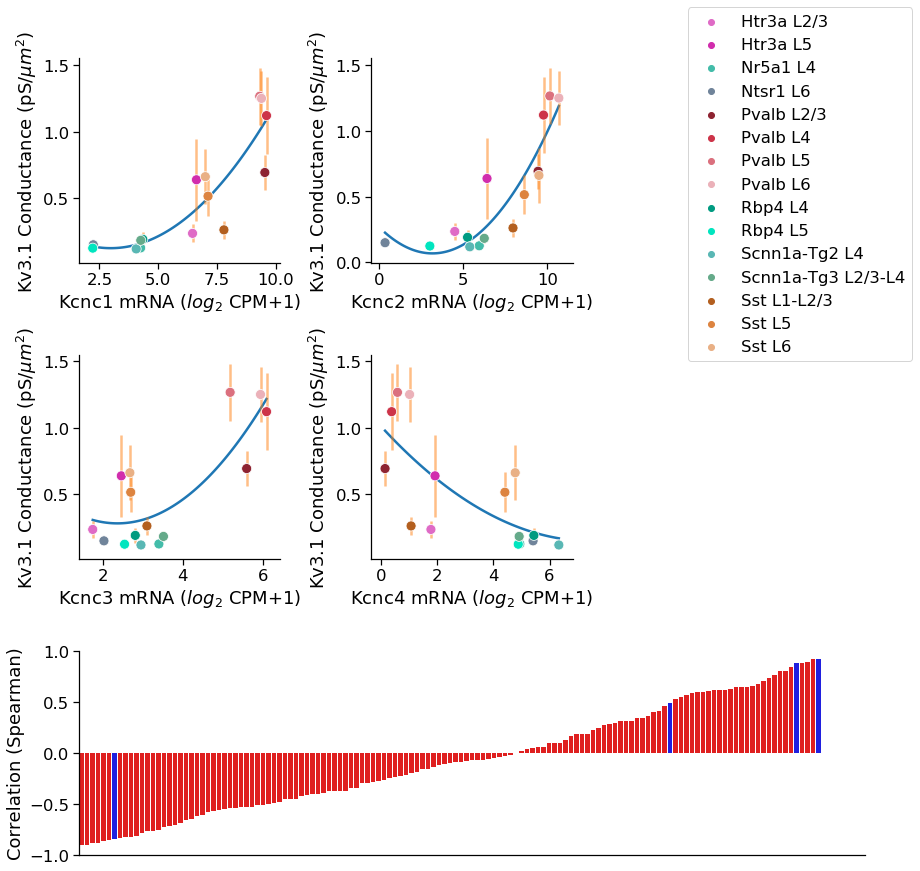

In [10]:
import matplotlib.gridspec as gridspec
# Initialize the grid with 3 rows and 3 columns
ncols = 3
nrows = 3
fig = plt.figure(figsize = (13, 14))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_conductance_exp('gbar_Kv3_1', 'Kcnc1', sep_layer_cre_parameter_df, 'Kcnc1 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

ax2 = fig.add_subplot(grid[0, 1])
ax2 = graph_conductance_exp('gbar_Kv3_1', 'Kcnc2', sep_layer_cre_parameter_df, 'Kcnc2 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

ax3 = fig.add_subplot(grid[1, 0])
ax3 = graph_conductance_exp('gbar_Kv3_1', 'Kcnc3', sep_layer_cre_parameter_df, 'Kcnc3 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

ax4 = fig.add_subplot(grid[1, 1])
ax4 = graph_conductance_exp('gbar_Kv3_1', 'Kcnc4', sep_layer_cre_parameter_df, 'Kcnc4 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

ax5 = fig.add_subplot(grid[2, :])
ax5 = histo_corr_new('gbar_Kv3_1', sep_spearman_corr_ranks, 'VGCCs', 'Correlation (Spearman)')

handles, labels = ax4.get_legend_handles_labels()
#ax6 = fig.add_subplot(grid[0:1, 2])
fig.legend(handles, labels, loc='upper right')


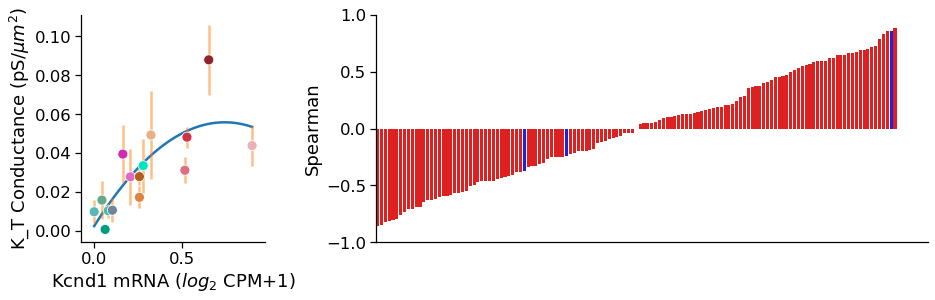

In [11]:
# K_T and Kcnd family 
ncols = 2
nrows = 1
fig = plt.figure(figsize = (14, 4))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.3, hspace=0.3, width_ratios=[1,3])


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_conductance_exp('gbar_K_T', 'Kcnd1', sep_layer_cre_parameter_df, 'Kcnd1 mRNA ($log_2$ CPM+1)', 'K_T Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

ax2 = fig.add_subplot(grid[0, 1])
ax2 = histo_corr_new('gbar_K_T', sep_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Kv3.1'),'Spearman')


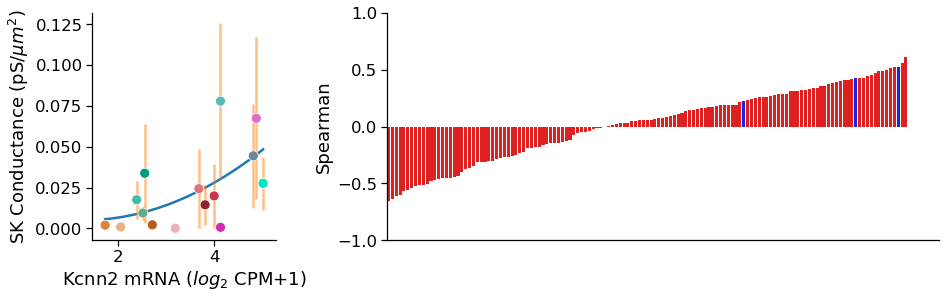

In [12]:
# SK and Kcnn2 family 
ncols = 2
nrows = 1
fig = plt.figure(figsize = (14, 4))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.3, hspace=0.3, width_ratios=[1,3])


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_conductance_exp('gbar_SK', 'Kcnn2', sep_layer_cre_parameter_df, 'Kcnn2 mRNA ($log_2$ CPM+1)', 'SK Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

ax2 = fig.add_subplot(grid[0, 1])
ax2 = histo_corr_new('gbar_SK', sep_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Kv3.1'),'Spearman')


In [51]:
def return_graph_conductance_exp_inh(parameter_type, gene_symbol, df, xlabel, ylabel):
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
    
    std_cre = sem.loc[cre_color_inc_4,:]
    errors = std_cre[parameter_type]
    inv_errors = 1/errors

    cre_color_inc_4.sort()
    inh_or_exc = []
    for thing in cre_color_inc_4:
        inh_or_exc.append(thing[-3:])
    
    graph_spec['Address'] = inh_or_exc

    graph_spec.index = range(15)
    graph_spec.rename(columns={gene_id: gene_symbol}, inplace= True)
    
    ax = sns.lmplot(x=gene_symbol, y=parameter_type, hue="Address", data=graph_spec)
    ax.set(xlabel=xlabel, ylabel=ylabel)

    ax = ax.axes[0,0]  # access a grid of 'axes' objects

    return ax


def create_cre_conductance_type(parameter_type, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_type , : ]
    return cre_conductance_filtered

def create_gene_spec_filtered_type(gene_symbol):
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inc_type])
    return gene_spec_filtered, gene_id

def rename_graph_spec_type(graph_spec):
    graph_spec.rename(index = {"Htr3a-Cre_NO152__L5__inh":"Htr3a L5", 
                               'Htr3a-Cre_NO152__L2/3__inh':'Htr3a L2/3',
                               'Nr5a1-Cre__L4__exc':'Nr5a1 L4',
                               'Ntsr1-Cre_GN220__L6__exc':'Ntsr1 L6',
             'Pvalb-IRES-Cre__L2/3__inh':'Pvalb L2/3',
             'Pvalb-IRES-Cre__L4__inh':'Pvalb L4',
             'Pvalb-IRES-Cre__L5__inh':'Pvalb L5',
             'Pvalb-IRES-Cre__L6__inh':'Pvalb L6',
             'Rbp4-Cre_KL100__L4__exc':'Rbp4 L4',
             'Rbp4-Cre_KL100__L5__exc':'Rbp4 L5',
             'Scnn1a-Tg2-Cre__L4__exc':'Scnn1a-Tg2 L4',
            'Scnn1a-Tg3-Cre__L2/3-L4__exc':'Scnn1a-Tg3 L2/3-L4',
                               'Sst-IRES-Cre__L1-L2/3__inh':'Sst L1-L2/3', 
             'Sst-IRES-Cre__L5__inh':'Sst L5',
             'Sst-IRES-Cre__L6__inh':'Sst L6'}, 
                                 inplace = True)
    
def create_graph_spec_type(parameter_type, gene_symbol, df):
    cre_conductance_filtered = create_cre_conductance_type(parameter_type, df)
   
    gene_spec_filtered, gene_id = create_gene_spec_filtered_type(gene_symbol)
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    
    rename_graph_spec_type(graph_spec)
    
    return graph_spec

def return_graph_conductance_exp_type(parameter_type, gene_symbol, df, xlabel, ylabel):
    
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
    
    cre_color_inc_4.sort()
    c_type = []
    for thing in cre_color_inc_4:
        if thing[-3:] == 'exc':
            c_type.append('Pyr')
        elif thing[0:5] == 'Pvalb':
            c_type.append('PV')
        elif thing[0:3] == 'Sst':
            c_type.append('Sst')
        elif thing[0:5] == 'Htr3a':
            c_type.append('Htr3')

    graph_spec['Address'] = c_type
    graph_spec.index = range(15)
    graph_spec.rename(columns={gene_id: gene_symbol}, inplace= True)
    ax = sns.lmplot(x=gene_symbol, y=parameter_type, hue="Address", data=graph_spec, truncate=True, ci=None)
    
    # ax = sns.scatterplot(x=gene_symbol, y=parameter_type, hue="Address", data=graph_spec)
    ax = ax.axes[0,0]  # access a grid of 'axes' objects
    
    
    return ax
    

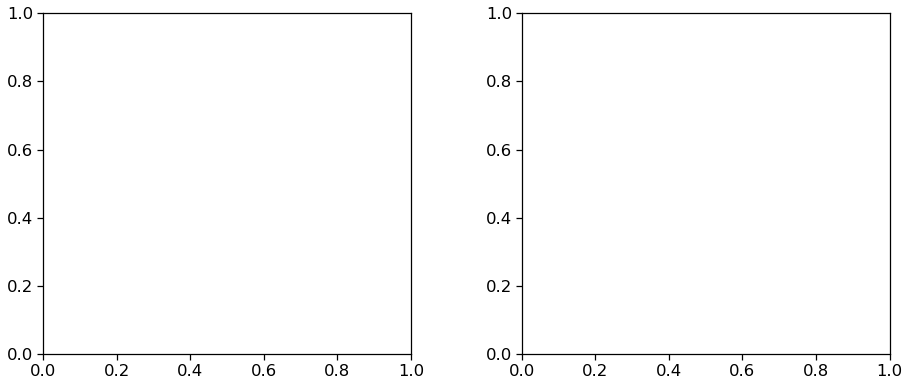

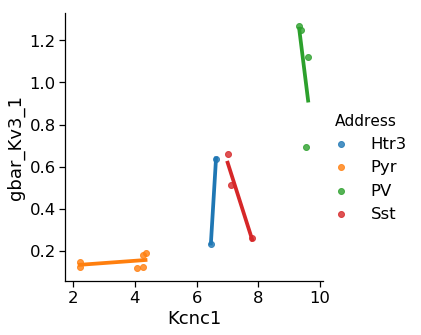

In [52]:
# SK and Kcnn2 family 
ncols = 2
nrows = 1
fig = plt.figure(figsize = (14, 6))
plt.tight_layout()


grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.3, hspace=0.3)

ax1 = fig.add_subplot(grid[0, 0])
#ax1 = return_graph_conductance_exp_inh('gbar_Kv3_1', 'Kcnc1', sep_layer_cre_parameter_df, 'Kcnc1 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)')

ax2 = fig.add_subplot(grid[0, 1])
ax2 = return_graph_conductance_exp_type('gbar_Kv3_1', 'Kcnc1', sep_layer_cre_parameter_df, 'Kcnc1 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)')

# plt.show()
# return_graph_conductance_exp_inh('gbar_SK', 'Kcnn2', sep_layer_cre_parameter_df, 'Kcnn2 mRNA ($log_2$ CPM+1)', 'SK Conductance (pS/$\mu m^2$)')
# return_graph_conductance_exp_type('gbar_SK', 'Kcnn2', sep_layer_cre_parameter_df, 'Kcnn2 mRNA ($log_2$ CPM+1)', 'SK Conductance (pS/$\mu m^2$)')

In [12]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_multiple(parameter_type, gene_symbols, df, xlabel, ylabel):
    if len(gene_symbols) == 4:
        i = 141
    elif len(gene_symbols) == 3:
        i = 141
    elif len(gene_symbols) == 2:
        i = 141
    plt.figure(figsize=(20, 5))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    for gene_symbol in gene_symbols:
        gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
        graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
        plt.subplot(i)
        plt.tight_layout()
        graph_conductance_exp(parameter_type, gene_symbol, sep_layer_cre_parameter_df, 'Kcnc2 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

#         std_cre = sem.loc[cre_color_inc_4,:]
#         errors = std_cre[parameter_type]
#         inv_errors = 1/errors

#         graph_spec.sort_values(by=[gene_id], inplace = True)
#         mini = graph_spec.iloc[0, :][gene_id]
#         maxi = graph_spec.iloc[14, :][gene_id]

#         graph_spec = create_graph_spec(parameter_type, gene_symbol, df)

#         plt.subplot(i)
#         plt.tight_layout()
#         z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=2)
#         p = np.poly1d(z)
#         xp = np.linspace(mini, maxi, 100)
#         _ = plt.plot(xp, p(xp), '-', zorder=1)
        

#         ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
#         if i != len(gene_symbols):
#             ax.get_legend().set_visible(False)
#         else:
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
#         plt.rcParams['font.family'] = 'sans-serif'
#         plt.rcParams['font.sans-serif'] = ['Tahoma']
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         ax.yaxis.set_ticks_position('left')
#         ax.xaxis.set_ticks_position('bottom')

#         ax.xaxis.label.set_size(15)
#         ax.yaxis.label.set_size(15)
#         ax.set(xlabel=gene_symbol+xlabel, ylabel=ylabel)

#         # Find the x,y coordinates for each point
#         x_coords = []
#         y_coords = []
#         for point_pair in ax.collections:
#             for x, y in point_pair.get_offsets():
#                 x_coords.append(x)
#                 y_coords.append(y)

#         ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
#         plt.tight_layout()
        i = i + 1
    plt.savefig("{}.svg".format(parameter_type), format="svg")
    plt.show()


In [23]:
# #Function for getting and saving spearman correlations into dictionary
# spearman_corr_ranks = {}
# excluded = []
# for parameter_ranks in parameters:
#     spearman_corr_ranks[parameter_ranks] = {}
#     cre_conductance_filtered = create_cre_conductance(parameter_ranks, sep_layer_cre_parameter_df)
    
#     for items in gene_channel:
#         gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == items]['Mouse Entrez Gene'])
#         if gene_id in transcriptome_df.index:
#             gene_spec_filtered, gene_id = create_gene_spec_filtered(items)

#             graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)

#             spearman_val = graph_spec.corr(method="spearman").iloc[0, 1]
#             spearman_corr_ranks[parameter_ranks][items] = spearman_val
#         else:
#             excluded.append(items)

# 

# jjson = json.dumps(spearman_corr_ranks)
# f = open("new_sep_spearman_corr_ranks.json","w")
# f.write(jjson)
# f.close()

# #Kcnh4 not included

{'gbar_Im': {'Kcnma1': 0.11666666666666667,
  'Kcnn1': -0.4666666666666667,
  'Kcnn2': -0.4,
  'Kcnn3': 0.3,
  'Kcnn4': nan,
  'Kcnt1': -0.5666666666666667,
  'Kcnt2': -0.1,
  'Kcnu1': -0.21666666666666667,
  'Catsper1': -0.5477225575051662,
  'Catsper2': -0.5166666666666667,
  'Catsper3': -0.25103950552320115,
  'Catsper4': -0.5477225575051662,
  'Tpcn1': 0.06666666666666667,
  'Tpcn2': -0.15,
  'Cnga1': nan,
  'Cnga2': -0.3051285766293647,
  'Cnga3': -0.4356649189097367,
  'Cnga4': -0.43333333333333335,
  'Cngb1': nan,
  'Cngb3': -0.25103950552320115,
  'Hcn1': -0.5166666666666667,
  'Hcn2': 0.08333333333333333,
  'Hcn3': 0.3,
  'Hcn4': 0.02970442628930023,
  'Kcnj1': nan,
  'Kcnj2': 0.03333333333333333,
  'Kcnj12': -0.45,
  'Kcnj4': -0.4,
  'Kcnj14': 0.23333333333333334,
  'Kcnj3': -0.13333333333333333,
  'Kcnj6': 0.08333333333333333,
  'Kcnj9': -0.1,
  'Kcnj5': -0.4107919181288746,
  'Kcnj10': -0.016951587590520262,
  'Kcnj15': nan,
  'Kcnj16': -0.11866111313364182,
  'Kcnj8': -0.1

In [104]:
#Graphing scatterplot of conductance and transcriptomics
def abs_graph_conductance_exp_inc_4(parameter_type, gene_symbols, df, xlabel, ylabel):
    if len(gene_symbols) == 4:
        i = 221
    elif len(gene_symbols) == 3:
        i = 221
    elif len(gene_symbols) == 2:
        i = 221
    plt.figure(figsize=(10, 10))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    for gene_symbol in gene_symbols:
        gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
        graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 

        std_cre = abs_sem.loc[cre_color_inc_4,:]
        errors = std_cre[parameter_type]
        inv_errors = 1/errors

        graph_spec.sort_values(by=[gene_id], inplace = True)
        mini = graph_spec.iloc[0, :][gene_id]
        maxi = graph_spec.iloc[14, :][gene_id]

        graph_spec = create_graph_spec(parameter_type, gene_symbol, df)

        plt.subplot(i)
        plt.tight_layout()
        z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=2, w=inv_errors)
        p = np.poly1d(z)
        xp = np.linspace(mini, maxi, 100)
        _ = plt.plot(xp, p(xp), '-', zorder=1)
        

        ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
        if i != len(gene_symbols):
            ax.get_legend().set_visible(False)
        else:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Tahoma']
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        ax.set(xlabel=gene_symbol+xlabel, ylabel=ylabel)

        # Find the x,y coordinates for each point
        x_coords = []
        y_coords = []
        for point_pair in ax.collections:
            for x, y in point_pair.get_offsets():
                x_coords.append(x)
                y_coords.append(y)

        ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
        plt.tight_layout()
        i = i + 1
    plt.savefig("{}.svg".format(parameter_type), format="svg")
    plt.show()


In [13]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_inc_4(parameter_type, gene_symbols, df, xlabel, ylabel):
    if len(gene_symbols) == 4:
        i = 141
    elif len(gene_symbols) == 3:
        i = 141
    elif len(gene_symbols) == 2:
        i = 141
    plt.figure(figsize=(20, 5))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    for gene_symbol in gene_symbols:
        gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
        graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 

        std_cre = sem.loc[cre_color_inc_4,:]
        errors = std_cre[parameter_type]
        inv_errors = 1/errors

        graph_spec.sort_values(by=[gene_id], inplace = True)
        mini = graph_spec.iloc[0, :][gene_id]
        maxi = graph_spec.iloc[14, :][gene_id]

        graph_spec = create_graph_spec(parameter_type, gene_symbol, df)

        plt.subplot(i)
        plt.tight_layout()
        z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=2)
        p = np.poly1d(z)
        xp = np.linspace(mini, maxi, 100)
        _ = plt.plot(xp, p(xp), '-', zorder=1)
        

        ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
        if i != len(gene_symbols):
            ax.get_legend().set_visible(False)
        else:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Tahoma']
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        ax.set(xlabel=gene_symbol+xlabel, ylabel=ylabel)

        # Find the x,y coordinates for each point
        x_coords = []
        y_coords = []
        for point_pair in ax.collections:
            for x, y in point_pair.get_offsets():
                x_coords.append(x)
                y_coords.append(y)

        ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
        plt.tight_layout()
        i = i + 1
    plt.savefig("{}.svg".format(parameter_type), format="svg")
    plt.show()
